## Linear Regression vs. Logistic Regression

In the previous tutorial we attempted to predict a person's annual medical charges using _linear regression_. In this tutorial, we'll use _logistic regression_, which is better suited for _classification_ problems like predicting whether it will rain tomorrow. Identifying whether a given problem is a _classfication_ or _regression_ problem is an important first step in machine learning.

### Classification Problems


Problems where each input must be assigned a discrete category (also called label or class) are known as _classification problems_. 

Classification problems can be binary (yes/no) or multiclass (picking one of many classes). 

But the output will be the probability of whether the thing that will happen or not.


### Regression Problems

Problems where a continuous numeric value must be predicted for each input are known as _regression problems_.

### Linear Regression for Solving Regression Problems

Linear regression is a commonly used technique for solving regression problems. In a linear regression model, the target is modeled as a linear combination (or weighted sum) of input features. The predictions from the model are evaluated using a loss function like the Root Mean Squared Error (RMSE).


Here's a visual summary of how a linear regression model is structured:

<img src="https://i.imgur.com/iTM2s5k.png" width="480">

### Logistic Regression for Solving Classification Problems

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured ([source](http://datahacker.rs/005-pytorch-logistic-regression-in-pytorch/)):


<img src="https://i.imgur.com/YMaMo5D.png" width="480">

The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">


The output of the sigmoid function is called a logistic, hence the name _logistic regression_. For a mathematical discussion of logistic regression, sigmoid activation and cross entropy. Logistic regression can also be applied to multi-class classification problems, with a few modifications.

### Machine Learning Workflow

Whether we're solving a regression problem using linear regression or a classification problem using logistic regression, the workflow for training a model is exactly the same `(when we use model.fit, the following steps occur)`:

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function (in case of logistic regression it is the probability of thing to be happen or not).  
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.


<img src="https://i.imgur.com/g32CoIy.png" width="480">


Classification and regression are both supervised machine learning problems, because they use labeled data. Machine learning applied to unlabeled data is known as unsupervised learning ([image source](https://au.mathworks.com/help/stats/machine-learning-in-matlab.html)). 
In this tutorial, we'll train a _logistic regression_ model using the Rain in Australia dataset to predict whether or not it will rain at a location tomorrow, using today's data. This is a _binary classification_ problem.



### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "./Data/weatherAUS.csv"
raw_df = pd.read_csv(path)
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/08,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,12/2/08,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12/3/08,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,12/4/08,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,12/5/08,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow','WindGustDir','WindDir3pm','WindDir9am'], inplace=True)

In [4]:
## checking data types of all columns
miss_val_df = pd.DataFrame(raw_df.dtypes, columns=['Data Type'])
miss_val_df['count of missing values'] = raw_df.isnull().sum()
miss_val_df = miss_val_df.sort_values(by='Data Type', ascending=False)
miss_val_df

,Data Type,count of missing values
Date,object,0
WindGustDir,object,0
RainToday,object,0
Location,object,0
WindDir3pm,object,0
WindDir9am,object,0
RainTomorrow,object,0
Sunshine,float64,56623
WindGustSpeed,float64,0
Evaporation,float64,50647


In [5]:
# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
print("Count of differnt year in our dataset - \n",pd.to_datetime(raw_df.Date).dt.year.value_counts().sum)

Count of differnt year in our dataset - 
 <bound method NDFrame._add_numeric_operations.<locals>.sum of Date
2016    15602
2015    15306
2014    15132
2013    14230
2009    14015
2010    13860
2011    13202
2012    13169
2017     7412
2008     1721
2007       61
Name: count, dtype: int64>


In [6]:
# Create training, validation and test sets
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]
print("Shape of Training Data: ", train_df.shape)
print("Shape of validation Data:", val_df.shape)
print("Shape of Testing Data:", test_df.shape)

Shape of Training Data:  (85390, 23)
Shape of validation Data: (15306, 23)
Shape of Testing Data: (23014, 23)


In [7]:
## Creating input (PREDICTOR) and Target Variables
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [8]:
# Creating training and testing copy for all the datasets
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

In [9]:
## Identifying numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [10]:
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [11]:
# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [12]:
# Scale numeric features
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [58]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [13]:
# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

### Model Training and Evaluation

In [17]:
train_inputs[numeric_cols + encoded_cols].isnull().sum()

MinTemp           0
MaxTemp           0
Rainfall          0
Evaporation       0
Sunshine          0
                 ..
WindDir3pm_W      0
WindDir3pm_WNW    0
WindDir3pm_WSW    0
RainToday_No      0
RainToday_Yes     0
Length: 112, dtype: int64

Accuracy: 82.08%
Accuracy: 79.84%


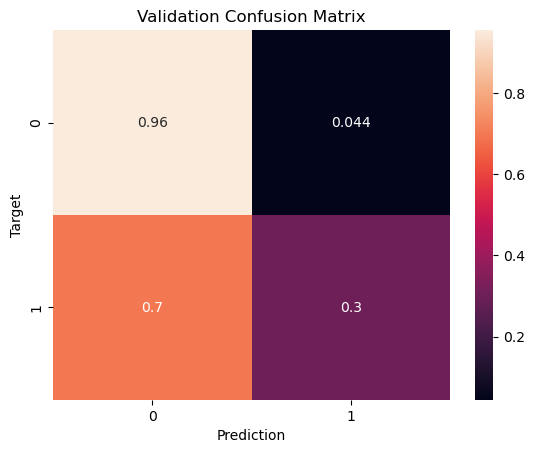

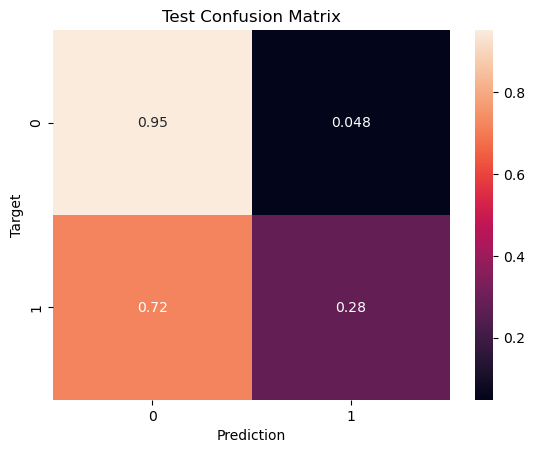

In [18]:
# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

# Generate predictions and probabilities
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));    
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# Save the trained model & load it back
aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
joblib.dump(aussie_rain, 'aussie_rain.joblib')
aussie_rain2 = joblib.load('aussie_rain.joblib')

### Prediction on Single Inputs 

In [16]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

('Yes', 0.9999999924710766)

## Summary and References

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured ([source](http://datahacker.rs/005-pytorch-logistic-regression-in-pytorch/)):


<img src="https://i.imgur.com/YMaMo5D.png" width="480">


To train a logistic regression model, we can use the `LogisticRegression` class from Scikit-learn. We covered the following topics in this tutorial:

- Downloading a real-world dataset from Kaggle
- Exploratory data analysis and visualization
- Splitting a dataset into training, validation & test sets
- Filling/imputing missing values in numeric columns
- Scaling numeric features to a $(0,1)$ range
- Encoding categorical columns as one-hot vectors
- Training a logistic regression model using Scikit-learn
- Evaluating a model using a validation set and test set
- Saving a model to disk and loading it back



Check out the following resources to learn more:

* https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Baseline
* https://jovian.ai/aakashns/03-logistic-regression


Try training logistic regression models on the following datasets:

- [Breast cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data): Predicting whether a tumor  is "benign" (noncancerous) or "malignant" (cancerous) using information like its radius, texture etc.
- [Loan Repayment Prediction](https://www.kaggle.com/c/home-credit-default-risk) - Predicting whether applicants will repay a home loan based on factors like age, income, loan amount, no. of children etc.
- [Handwritten Digit Recognition](https://www.kaggle.com/c/digit-recognizer) - Identifying which digit from 0 to 9 a picture of handwritten text represents.